In [1]:
from cmdstanpy import cmdstan_path, CmdStanModel

import arviz as az
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

In [2]:
import cmdstanpy
cmdstanpy.install_cmdstan()
a=cmdstan_path()

Installing CmdStan version: 2.31.0
Install directory: /root/.cmdstan
Download successful, file: /tmp/tmprqttehmb
Extracting distribution


DEBUG:cmdstanpy:cmd: make build -j1
cwd: None


Unpacked download as cmdstan-2.31.0
Building version cmdstan-2.31.0, may take several minutes, depending on your system.


DEBUG:cmdstanpy:cmd: make examples/bernoulli/bernoulli
cwd: None


Test model compilation
Installed cmdstan-2.31.0


In [3]:
# Importing 2018-19 season results
Xall=pd.read_csv("season-1819_csv.csv")
cols = Xall.columns
X=Xall[['Date','HomeTeam','AwayTeam','FTR']]
X.head()

,Date,HomeTeam,AwayTeam,FTR
0,18/08/2018,Chievo,Juventus,A
1,18/08/2018,Lazio,Napoli,A
2,19/08/2018,Bologna,Spal,A
3,19/08/2018,Empoli,Cagliari,H
4,19/08/2018,Parma,Udinese,D


In [4]:
# Importing 2017-18 season results
Xall=pd.read_csv("season-1718_csv.csv")
cols = Xall.columns
X_old=Xall[['Date','HomeTeam','AwayTeam','FTR']]
X_old.head()

,Date,HomeTeam,AwayTeam,FTR
0,19/08/17,Juventus,Cagliari,H
1,19/08/17,Verona,Napoli,A
2,20/08/17,Atalanta,Roma,A
3,20/08/17,Bologna,Torino,D
4,20/08/17,Crotone,Milan,A


###Controllo le squadre che scendono in B e quelle che salgono in A

Scendono: Benevento, Crotone, Verona


Salgono: Empoli, Frosinone,Parma

In [5]:
Teams_old=list(X_old.iloc[:,1].unique())
Teams_old=sorted(Teams_old)
Teams_old

['Atalanta',
 'Benevento',
 'Bologna',
 'Cagliari',
 'Chievo',
 'Crotone',
 'Fiorentina',
 'Genoa',
 'Inter',
 'Juventus',
 'Lazio',
 'Milan',
 'Napoli',
 'Roma',
 'Sampdoria',
 'Sassuolo',
 'Spal',
 'Torino',
 'Udinese',
 'Verona']

In [6]:
Teams=list(X.iloc[:,1].unique())
Teams=sorted(Teams)
Teams #Salgono in serie A frosinone parma empoli

['Atalanta',
 'Bologna',
 'Cagliari',
 'Chievo',
 'Empoli',
 'Fiorentina',
 'Frosinone',
 'Genoa',
 'Inter',
 'Juventus',
 'Lazio',
 'Milan',
 'Napoli',
 'Parma',
 'Roma',
 'Sampdoria',
 'Sassuolo',
 'Spal',
 'Torino',
 'Udinese']

In [7]:
X_old.loc[X_old.HomeTeam == 'Benevento', 'HomeTeam'] = 'Frosinone'
X_old.loc[X_old.AwayTeam == 'Benevento', 'AwayTeam'] = 'Frosinone'

X_old.loc[X_old.HomeTeam == 'Crotone', 'HomeTeam'] = 'Empoli'
X_old.loc[X_old.AwayTeam == 'Crotone', 'AwayTeam'] = 'Empoli'

X_old.loc[X_old.HomeTeam == "Verona", 'HomeTeam'] = 'Parma'
X_old.loc[X_old.AwayTeam == "Verona", 'AwayTeam'] = 'Parma'

Teams_old=list(X_old.iloc[:,1].unique())
Teams_old=sorted(Teams_old)
pd.options.mode.chained_assignment = None  # default='warn'


/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:723: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [8]:
Teams_old==Teams

True

In [9]:
Y = np.array([2 if(X.iloc[i,3]=='H') else(0 if(X.iloc[i,3]=='A') else(1)) for i in range(X.shape[0])])

X['Y']=Y.tolist()
X.head()

,Date,HomeTeam,AwayTeam,FTR,Y
0,18/08/2018,Chievo,Juventus,A,0
1,18/08/2018,Lazio,Napoli,A,0
2,19/08/2018,Bologna,Spal,A,0
3,19/08/2018,Empoli,Cagliari,H,2
4,19/08/2018,Parma,Udinese,D,1


(array([106.,   0.,   0.,   0.,   0., 108.,   0.,   0.,   0., 166.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

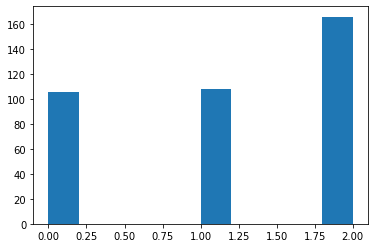

In [10]:
plt.hist(Y)

### Matrix and old skill computation

In [22]:
def names_to_index(Teams):

    """
    Creates a dictionary that associates teams to number
    """
    # dictionary comprehension
    d = {index: value for value, index in enumerate(Teams)}

    return d

In [23]:
def crea_matrici(X):
    """
    Takes as input a matrix X and their result to create two additional matrices that can be used for our model
    """
    #matrice casa trasferta risultato in numeri (N_match, 3)
    Y = np.array([3 if(X.iloc[i,3]=='H') else(0 if(X.iloc[i,3]=='A') else(1)) for i in range(X.shape[0])])
    
    Teams=list(X.iloc[:,1].unique())
    Teams=sorted(Teams)
    d = names_to_index(Teams)
    
    T_1 = np.array([d[X.iloc[i,1]] for i in range(X.shape[0])])
    T_2 = np.array([d[X.iloc[i,2]] for i in range(X.shape[0])])
    R = pd.DataFrame({"Home":T_1,"Away":T_2,"Result":Y})
    
    #matrice di storie delle squadre, casa-trasferta (N_Teams, 2)
    dim_vec_home = R['Home'].value_counts()
    dim_vec_away = R['Away'].value_counts()
    
    R2 = pd.DataFrame(index = sorted(np.unique(T_1)), columns = ["Home", "Away"])
    
    for i in range(len(np.unique(T_1))):
        R2["Home"][i] = np.empty(0,dtype = np.int8)
        R2["Away"][i] = np.empty(0,dtype = np.int8)
        
    for i in range(len(T_1)):
        h = R["Home"][i]
        a = R["Away"][i]
        R2["Home"][h] = np.append(R2["Home"][h],R["Result"][i])
        if(R["Result"][i]==1):                                      #Caso pareggi 1 punto
          R2["Away"][a] = np.append(R2["Away"][a], R["Result"][i])
        else:                                                       #Sconfitta 0 punti
          R2["Away"][a] = np.append(R2["Away"][a], 3 - R["Result"][i])
        
    
    
    return R,R2


In [24]:
def compute_skills(R,R2,init_home,init_away):
    """
    Takes as inputs a matrix X with teams and their result
    init is the inizialization of the skills, must be an array or list with the skill for each team.

    Returns two matrices with home and away skills parameters by team 
    and one matrix with skills parameters oredered cronologically
    """
    import numpy as np
    import pandas as pd

    N=R.shape[0] # number of matches
    
    #Lambda initialization
    l1 = 0.5
    l2 = 0.5

    #Creating matrices to store the skill parameters and their stories
        
    HS = pd.DataFrame(index = R2.index, columns = ["Home", "Away"])
    
    for i in range(R2.shape[0]):
        HS["Home"][i] = np.empty(0)
        HS["Away"][i] = np.empty(0)
        
    data = pd.DataFrame(index = R.index, columns=['Home','Away'])
    C = pd.DataFrame({"Home": np.zeros(len(R2.index), dtype = np.int8), "Away": np.zeros(len(R2.index), dtype = np.int8)})
    
    for i in range(R.shape[0]):
        h = R["Home"][i]
        a = R["Away"][i]

        # HOME SKILL
        if(C["Home"][h]==0):
          xh = init_home[h]
        else:
          #calcolo somma per xh
          sh = 0
          for j in range(C["Home"][h]):
              sh = sh + R2["Home"][h][j]*(1-l1)**j
        
          xh = l1*sh + init_home[h]*(1-l1)**C["Home"][h]

     # AWAY SKILL       
        if(C["Away"][a]==0):
          xv = init_away[a]
        else:
          #calcolo somma per xv
          sa = 0
          for j in range(C["Away"][a]):
             sa = sa + R2["Away"][a][j]*(1-l2)**j
        
          xv = l2*sa + init_away[a]*(1-l2)**C["Away"][a]        

        #append nostra matrice storico e dati per stan
        HS["Home"][h] = np.append(HS["Home"][h],round(xh,3))
        HS["Away"][a] = np.append(HS["Away"][a],round(xv,3))
        data["Home"][i] = round(xh,3)
        data["Away"][i] = round(xv,3)
        
        #incremento counts
        C["Home"][h] += 1
        C["Away"][a] += 1

    
    return HS,data

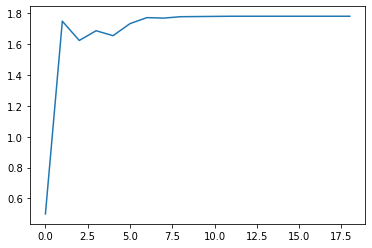

In [25]:
R_old, R2_old = crea_matrici(X)
HS_old, data_old = compute_skills(R_old, R2_old, 0.5*np.ones(len(Teams)), 0.5*np.ones(len(Teams)))

plt.plot(HS_old["Home"][0])

In [26]:
init_home = np.empty(0)
init_away = np.empty(0)

for i in range(HS_old.shape[0]):
  init_home = np.append(init_home,HS_old["Home"][i][-1])
  init_away = np.append(init_away,HS_old["Away"][i][-1])

R,R2 = crea_matrici(X)
HS_old, data = compute_skills(R, R2, init_home, init_away)

## Final model

In [27]:
ordinal_reg = '''
data { int<lower=0> N; // number of observations  
      matrix[N,2] X; // predictor variable values 
      array[N] int y; // observed ordinal outcome variable 
}

parameters { vector[2] beta; // coefficients for predictor variables
            real intercept1;
            real<lower=intercept1+0.0001,upper=100000> intercept2;
}
transformed parameters {
  vector[N] mu;
  vector[2] intercept;
  intercept[1] = intercept1;
  intercept[2] = intercept2;

  for (i in 1:N) { 
    mu[i] = row(X, i) * beta;
  }
}

model { // calculate likelihood of ordinal categories given predictor variable values and coefficients 
       for (i in 1:2){
          beta[i] ~ normal(0,3);  
       }

       intercept1 ~ normal(0,3);
       intercept2 ~ normal(0,3);

       for (i in 1:N) { 
         y[i] ~ ordered_logistic(mu[i],intercept); } 
       } 

'''

stan_file = "./ordinal_reg.stan"

with open(stan_file, "w") as f:
    print(ordinal_reg, file=f)

ordinal_reg = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /content/ordinal_reg
07:17:16 - cmdstanpy - INFO - compiling stan file /content/ordinal_reg.stan to exe file /content/ordinal_reg
INFO:cmdstanpy:compiling stan file /content/ordinal_reg.stan to exe file /content/ordinal_reg
DEBUG:cmdstanpy:cmd: make /content/ordinal_reg
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/ordinal_reg.hpp /content/ordinal_reg.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content

In [28]:
ordinal_reg = '''
data { int<lower=0> N; // number of observations  
      matrix[N,2] X; // predictor variable values 
      array[N] int y; // observed ordinal outcome variable 
}

parameters {real beta1;
            real beta2;
            real beta01;
            real<lower=beta01+0.0001,upper=100000> beta02;
}
transformed parameters {
  vector[N] mu;

  vector[2] intercept;
  intercept[1] = beta01;
  intercept[2] = beta02;

  vector[2] beta;
  beta[1] = beta1;
  beta[2] = beta2;

  for (i in 1:N) { 
    mu[i] = row(X, i) * beta;
  }
}

model { // calculate likelihood of ordinal categories given predictor variable values and coefficients 

       beta01 ~ normal(0,3);
       beta02 ~ normal(0,3);
       beta1 ~ normal(0,3);
       beta2 ~ normal(0,3);

       for (i in 1:N) { 
         y[i] ~ ordered_logistic(mu[i],intercept); } 
       } 

'''

stan_file = "./ordinal_reg.stan"

with open(stan_file, "w") as f:
    print(ordinal_reg, file=f)

ordinal_reg = CmdStanModel(stan_file=stan_file)

DEBUG:cmdstanpy:Removing /content/ordinal_reg
07:17:34 - cmdstanpy - INFO - compiling stan file /content/ordinal_reg.stan to exe file /content/ordinal_reg
INFO:cmdstanpy:compiling stan file /content/ordinal_reg.stan to exe file /content/ordinal_reg
DEBUG:cmdstanpy:cmd: make /content/ordinal_reg
cwd: /root/.cmdstan/cmdstan-2.31.0
DEBUG:cmdstanpy:Console output:

--- Translating Stan model to C++ code ---
bin/stanc  --o=/content/ordinal_reg.hpp /content/ordinal_reg.stan

--- Compiling, linking C++ code ---
g++ -std=c++1y -pthread -D_REENTRANT -Wno-sign-compare -Wno-ignored-attributes      -I stan/lib/stan_math/lib/tbb_2020.3/include    -O3 -I src -I stan/src -I stan/lib/rapidjson_1.1.0/ -I lib/CLI11-1.9.1/ -I stan/lib/stan_math/ -I stan/lib/stan_math/lib/eigen_3.3.9 -I stan/lib/stan_math/lib/boost_1.78.0 -I stan/lib/stan_math/lib/sundials_6.1.1/include -I stan/lib/stan_math/lib/sundials_6.1.1/src/sundials    -DBOOST_DISABLE_ASSERTS          -c -Wno-ignored-attributes   -x c++ -o /content

In [29]:
model_data={"N":len(Y), "y":Y+1, "X":data.values.tolist()}

model_fit=ordinal_reg.sample(data=model_data, chains=4,
                           parallel_chains=4, iter_warmup=1000,
                           iter_sampling=5000)
model_data=az.from_cmdstanpy(model_fit)


DEBUG:cmdstanpy:input tempfile: /tmp/tmpv13tcamh/bb1qid8_.json
DEBUG:cmdstanpy:cmd: /content/ordinal_reg info
cwd: None
07:17:50 - cmdstanpy - INFO - CmdStan start processing
INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:idx 1
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/ordinal_reg', 'id=2', 'random', 'seed=65801', 'data', 'file=/tmp/tmpv13tcamh/bb1qid8_.json', 'output', 'file=/tmp/tmpv13tcamh/ordinal_regq9rbud5l/ordinal_reg-20230213071750_2.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:CmdStan args: ['/content/ordinal_reg', 'id=1', 'random', 'seed=65801', 'data', 'file=/tmp/tmpv13tcamh/bb1qid8_.json', 'output', 'file=/tmp/tmpv13tcamh/ordinal_regq9rbud5l/ordinal_reg-20230213071750_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
DEBUG:cmdstanpy:idx 2
DEBUG:cmdstanpy:running CmdStan, num_threads: 1
DEBUG:cmdstanpy:CmdStan args: ['/content/ordinal_reg', 'id=3', 'random', 'seed=65801', 'data', 'file=/tmp/tmpv13tcamh/bb1qid8_.json', 'output', 'file=/tmp/t

07:19:01 - cmdstanpy - INFO - CmdStan done processing.
INFO:cmdstanpy:CmdStan done processing.
DEBUG:cmdstanpy:runset
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['/content/ordinal_reg', 'id=1', 'random', 'seed=65801', 'data', 'file=/tmp/tmpv13tcamh/bb1qid8_.json', 'output', 'file=/tmp/tmpv13tcamh/ordinal_regq9rbud5l/ordinal_reg-20230213071750_1.csv', 'method=sample', 'num_samples=5000', 'num_warmup=1000', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[0, 0, 0, 0]
 per-chain output files (showing chain 1 only):
 csv_file:
	/tmp/tmpv13tcamh/ordinal_regq9rbud5l/ordinal_reg-20230213071750_1.csv
 console_msgs (if any):
	/tmp/tmpv13tcamh/ordinal_regq9rbud5l/ordinal_reg-20230213071750_0-stdout.txt
DEBUG:cmdstanpy:Chain 1 console:
method = sample (Default)
  sample
    num_samples = 5000
    num_warmup = 1000 (Default)
    save_warmup = 0 (Default)
    thin = 1 (Default)
    adapt
      engaged = 1 (Default)
      gamma = 0.050000000000000003 (Default)
      

In [30]:
cmdstanpy_data = az.from_cmdstanpy(model_fit)
np.sum(cmdstanpy_data.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
array(0)

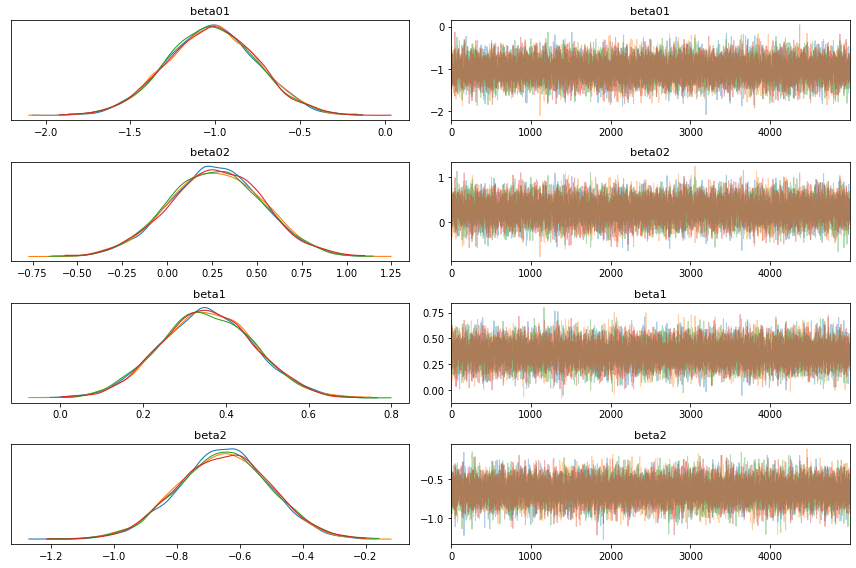

In [31]:
az.plot_trace(model_data, var_names=["beta01","beta02","beta1","beta2"], compact=False)
plt.tight_layout()
plt.savefig('vanillacalcio1')
plt.show()
